In [ ]:
!pip3 install tensorflow

In [ ]:
!pip3 install scikeras


In [113]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt
from functions.naming import rename_columns

# Load the data
df = pd.read_excel("/Users/athanasioskaravangelis/Desktop/RSM BAM/Workshop/pko_forecasting/data/PKO_Initial_Dataset.xlsx")
#rename columns
df = rename_columns(df)
# select only the values after 2010-01-01
df['date'] = pd.to_datetime(df['date'], format='%b-%y')
df = df[df['date'] > '2009-12-02']

# create lagged features for pko_fob_malaysia
num_lags = 3  # Choose an appropriate number of lag features

for i in range(1, num_lags + 1):
    df[f'pko_fob_malaysia_lag_{i}'] = df['pko_fob_malaysia'].shift(i)

# Drop the rows with NaN values in the pko_fob_malaysia_lag_{i} columns
df.dropna(subset=[f'pko_fob_malaysia_lag_{i}' for i in range(1, num_lags + 1)], inplace=True)

In [114]:
df.head()

,ONI,Precipitation_Indonesia,Precipitation_Malaysia,Temperaturemin_Indonesia,Temperaturemin_Malaysia,Temperaturemax_Indonesia,Temperaturemax_Malaysia,Humidex_Indonesia,Humidex_Malaysia,date,...,pko_total_supply_malaysia,pmi_indonesia,pmi_malaysia,export_tarrifs_indonesia,cpopc_mal_ind_2015,mspo_certification,ispo_certification,pko_fob_malaysia_lag_1,pko_fob_malaysia_lag_2,pko_fob_malaysia_lag_3
51,NaN,0.412347,0.294569,23.15416,23.68263,31.53292,32.85302,37.50045,39.29284,2010-04-01,...,NaN,NaN,NaN,100.0,0.0,0.0,0.0,1062.0,913.0,905.0
52,NaN,0.402333,0.315503,23.38245,23.89869,31.51028,32.93819,37.76451,39.94663,2010-05-01,...,NaN,NaN,NaN,100.0,0.0,0.0,0.0,1073.0,1062.0,913.0
53,NaN,0.366941,0.353968,22.12406,23.55412,30.82028,32.44298,36.28735,38.60072,2010-06-01,...,NaN,NaN,NaN,100.0,0.0,0.0,0.0,1074.0,1073.0,1062.0
54,NaN,0.361414,0.394614,21.71208,23.15089,30.30461,31.74550,35.41049,37.54654,2010-07-01,...,NaN,NaN,NaN,100.0,0.0,0.0,0.0,1081.0,1074.0,1073.0
55,NaN,0.347655,0.322497,21.93047,23.16723,30.71581,32.12675,35.53044,37.86630,2010-08-01,...,NaN,NaN,NaN,100.0,0.0,0.0,0.0,1131.0,1081.0,1074.0


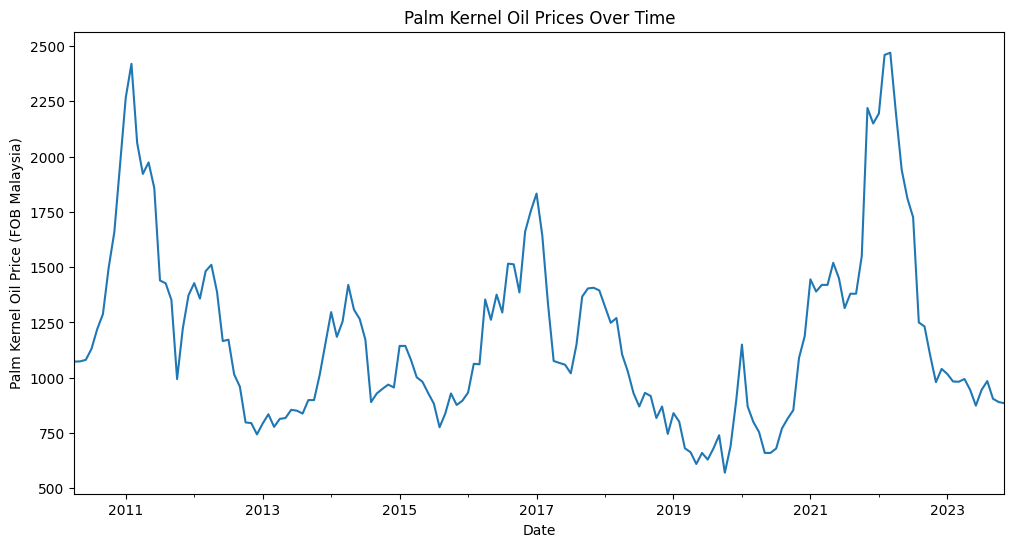

In [115]:
# Set 'date' as the index
df.set_index('date', inplace=True)

# Plot the time series data
df['pko_fob_malaysia'].plot(figsize=(12, 6))
plt.title('Palm Kernel Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Palm Kernel Oil Price (FOB Malaysia)')
plt.show()

In [116]:
# Specify columns to exclude
exclude_columns = [
    'indonesia_disaster', 'malaysia_disaster', 'jet_fuel_us', 'jet_fuel_europe', 'soybean_oil_zlz2',
    'tallow_fob_us_gulf', 'palm_olein_fob_malaysia',
    'palm_stearin_cif_rotterdam', 'fatty_alcohol_c12_14_fob_asia', 'fatty_alcohol_c16_18_fob_asia',
    'fatty_alcohol_c12_14_fd_nwe', 'jet_fuel_us_usd_mt', 'rspo', 'bio_ethanol', 'cpopc_mal_ind_2015', 'mspo_certification', 'ispo_certification',
    'export_tarrifs_indonesia', 'palm_oil_cif_nwe'
]

# Filter the dataset to exclude specified columns
df_filtered = df.drop(columns=exclude_columns)

# Update NUM_FEATURES based on the filtered dataset
num_features = df_filtered.shape[1]
num_features

# fill nas with average values
df = df_filtered.fillna(df_filtered.mean())

# Normalize the data
scaler = MinMaxScaler()
a = 0
if a:
    df = df.drop(['pko_cif_rotterdam'],axis=1)
    df_scaled = scaler.fit_transform(df[['pko_fob_malaysia']])
else:
    df = df.drop(['pko_fob_malaysia'],axis=1)
    df_scaled = scaler.fit_transform(df[['pko_cif_rotterdam']])
    

# Create sequences for training the GRU
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Choose sequence length and split data into train and test sets
sequence_length = 12
train_size = int(len(df_scaled)*0.8)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

# Create sequences for training
X_train, y_train = create_sequences(train_data, sequence_length)

In [117]:
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

# Create GRU model
def create_gru_model():
    model = Sequential()
    model.add(GRU(128, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [118]:
# Reshape input data for GRU model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

model = create_gru_model()
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
4/4 [==============================] - 2s 287ms/step - loss: 0.0851
Epoch 2/50
4/4 [==============================] - 1s 170ms/step - loss: 0.0479
Epoch 3/50
4/4 [==============================] - 1s 146ms/step - loss: 0.0251
Epoch 4/50
4/4 [==============================] - 1s 145ms/step - loss: 0.0136
Epoch 5/50
4/4 [==============================] - 1s 140ms/step - loss: 0.0146
Epoch 6/50
4/4 [==============================] - 1s 127ms/step - loss: 0.0151
Epoch 7/50
4/4 [==============================] - 1s 131ms/step - loss: 0.0116
Epoch 8/50
4/4 [==============================] - 1s 164ms/step - loss: 0.0117
Epoch 9/50
4/4 [==============================] - 1s 169ms/step - loss: 0.0107
Epoch 10/50
4/4 [==============================] - 1s 141ms/step - loss: 0.0117
Epoch 11/50
4/4 [==============================] - 1s 170ms/step - loss: 0.0097
Epoch 12/50
4/4 [==============================] - 1s 146ms/step - loss: 0.0093
Epoch 13/50
4/4 [==============================] 

In [119]:
# Create sequences for testing
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape input data for GRU model
print((X_test.shape[0], X_test.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(np.mean((y_test_inverse - y_pred_inverse)**2))
print('Root Mean Squared Error (RMSE):', rmse)
# calculate MAE
mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
print('Mean Absolute Error (MAE):', mae)
# calculate MSLE 
msle = np.mean(np.square(np.log(y_test_inverse + 1) - np.log(y_pred_inverse + 1)))
print('Mean Squared Log Error (MSLE):', msle)

(21, 12)
1/1 [==============================] - 0s 314ms/step
Root Mean Squared Error (RMSE): 101.83485990629222
Mean Absolute Error (MAE): 68.5161801292783
Mean Squared Log Error (MSLE): 0.004271480820335118


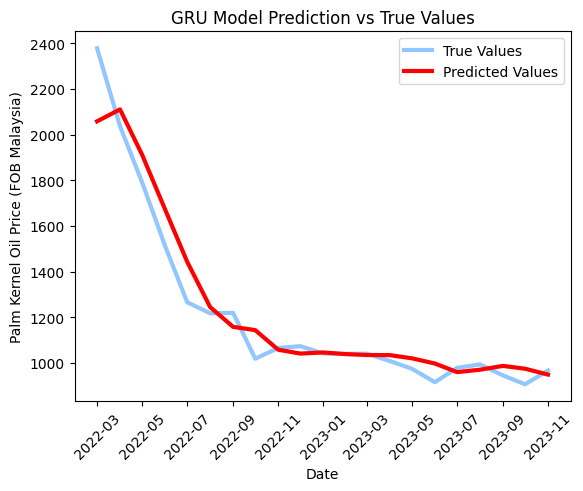

In [151]:
# Plot the results
# show straight vertical lines for every month
# X-AXIS LABELS 45 DEGREES
plt.xticks(rotation=45)
plt.plot(df.index[train_size+sequence_length:], y_test_inverse, label='True Values')
plt.plot(df.index[train_size+sequence_length:], y_pred_inverse, label='Predicted Values', color='red')
plt.title('GRU Model Prediction vs True Values')
plt.xlabel('Date')
plt.ylabel('Palm Kernel Oil Price (FOB Malaysia)')
plt.style.use('seaborn-v0_8-pastel')
plt.legend()
plt.show()

In [121]:
# show predictions for the next 8 months like date, predicted value, true value
df_results = pd.DataFrame()
df_results['date'] = df.index[train_size+sequence_length:]
df_results['true_value'] = y_test_inverse
df_results['predicted_value'] = y_pred_inverse
df_results['difference'] = df_results['true_value'] - df_results['predicted_value']
df_results

,date,true_value,predicted_value,difference
0,2022-03-01,2378.0,2057.967773,320.032227
1,2022-04-01,2037.0,2110.222168,-73.222168
2,2022-05-01,1790.0,1911.133301,-121.133301
3,2022-06-01,1512.0,1671.948730,-159.948730
4,2022-07-01,1265.0,1442.064819,-177.064819
5,2022-08-01,1217.0,1244.028931,-27.028931
6,2022-09-01,1219.0,1157.555420,61.444580
7,2022-10-01,1018.0,1143.242676,-125.242676
8,2022-11-01,1065.0,1057.438721,7.561279
9,2022-12-01,1073.0,1040.422485,32.577515


In [122]:
# Generate synthetic future data
def generate_future_data(model, initial_sequence, future_steps):
    generated_data = initial_sequence.copy()

    for _ in range(future_steps):
        # Reshape the sequence for model input
        input_sequence = generated_data[-18:].reshape(1, -1, 1)

        # Make a prediction
        predicted_value = model.predict(input_sequence)[0, 0]

        # Append the predicted value to the generated data
        generated_data = np.append(generated_data, predicted_value)

    return generated_data


In [141]:
initial_sequence = test_data[-12:]
future_steps = 12  # Adjust as needed for the number of future steps you want to predict

# Generate synthetic future data
generated_future_data = generate_future_data(model, initial_sequence, future_steps)

# Inverse transform to get actual values
predicted_future_values = scaler.inverse_transform(generated_future_data.reshape(-1, 1))

# Create a time index for the future data
future_time_index = pd.date_range(start='2023-11-30', periods=future_steps, freq='MS')

# Create a DataFrame with the predicted future values
predicted_future_df = pd.DataFrame({'date': future_time_index, 'predicted_value': predicted_future_values.flatten()[-12:]})

# Display the predicted future data
print(predicted_future_df)

1/1 [==============================] - 0s 59ms/step
         date  predicted_value
0  2023-12-01       962.229356
1  2024-01-01       970.689893
2  2024-02-01       978.640105
3  2024-03-01       985.744251
4  2024-04-01       991.911466
5  2024-05-01       997.167607
6  2024-06-01      1001.591674
7  2024-07-01      1005.283971
8  2024-08-01      1008.345392
9  2024-09-01      1010.872026
10 2024-10-01      1012.950132
11 2024-11-01      1014.655023


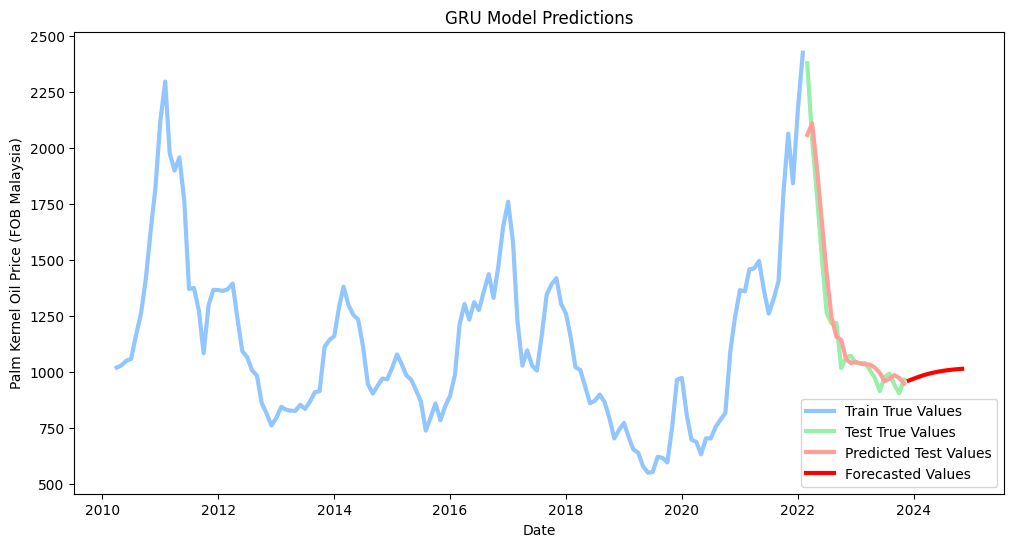

In [146]:
# now plot the true values of the train and test set and then the future predicted values, plot after 2016

# make plot line bold and bigger
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(12, 6))
plt.plot(df.index[:train_size+sequence_length], df['pko_cif_rotterdam'][:train_size+sequence_length], label='Train True Values')
plt.plot(df.index[train_size+sequence_length:], df['pko_cif_rotterdam'][train_size+sequence_length:], label='Test True Values')
#plot with dashed line the line connecting the last value of train and first value of test set
#plt.plot([df.index[train_size+sequence_length-1], df.index[train_size+sequence_length]], [df['pko_cif_rotterdam'][train_size+sequence_length-1], df['pko_cif_rotterdam'][train_size+sequence_length]], linestyle='dashed')
# also plot the predicted test values
plt.plot(df_results['date'], df_results['predicted_value'], label='Predicted Test Values')
plt.plot(predicted_future_df['date'], predicted_future_df['predicted_value'], label='Forecasted Values', color='red')
plt.title('GRU Model Predictions')
plt.xlabel('Date')
plt.ylabel('Palm Kernel Oil Price (FOB Malaysia)')
# add a nice theme 
plt.style.use('seaborn-v0_8-pastel')
plt.legend()
plt.show()

In [132]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']